# Decision Trees - Michał Madej
-----------------------------------------------------------------

In [29]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split , KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn.model_selection import GridSearchCV, StratifiedKFold,cross_val_score

In [30]:
iris = pd.read_csv('iris.data', names=["SepalLengthCm","SepalWidthCm","PetalLengthCm","PetalWidthCm","Species"])
iris.head(10)

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
5,5.4,3.9,1.7,0.4,Iris-setosa
6,4.6,3.4,1.4,0.3,Iris-setosa
7,5.0,3.4,1.5,0.2,Iris-setosa
8,4.4,2.9,1.4,0.2,Iris-setosa
9,4.9,3.1,1.5,0.1,Iris-setosa


In [31]:
x = iris.iloc[:, :-1]
y = iris.iloc[:, -1]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle = True, random_state=1)

clf = DecisionTreeClassifier() 

In [32]:
clf.fit(x_train, y_train) 

k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
k_fold_scores = cross_val_score(clf, x_train, y_train, cv=k_fold)
print('K-fold cross-validation scores:', k_fold_scores)
print('Mean score:', k_fold_scores.mean())

# Stratyfikowany k-fold cross-validation
stratified_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
stratified_k_fold_scores = cross_val_score(clf, x_train, y_train, cv=stratified_k_fold)
print('Stratified k-fold cross-validation scores:', stratified_k_fold_scores)
print('Mean score:', stratified_k_fold_scores.mean())


K-fold cross-validation scores: [0.95238095 0.95238095 0.95238095 0.95238095 0.95238095]
Mean score: 0.9523809523809523
Stratified k-fold cross-validation scores: [0.9047619  1.         0.9047619  1.         0.95238095]
Mean score: 0.9523809523809523


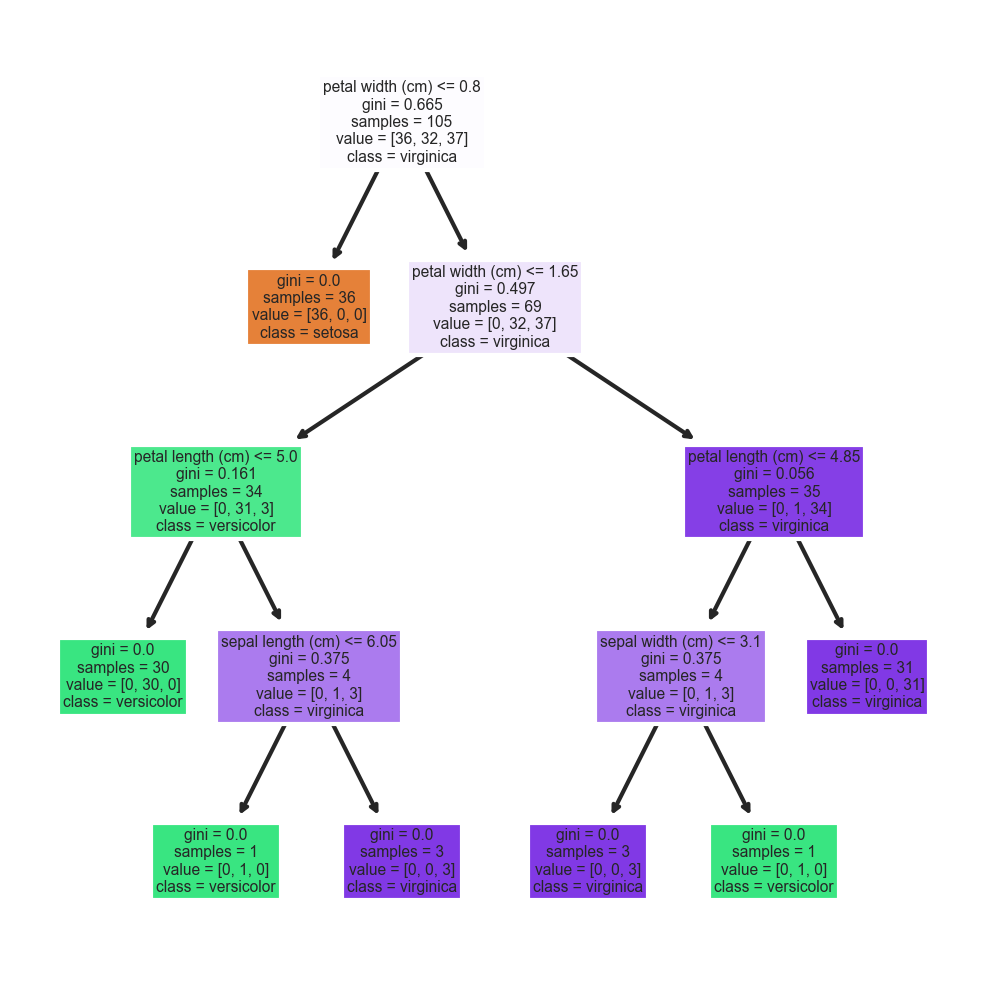

In [33]:
fn=['sepal length (cm)','sepal width (cm)','petal length (cm)','petal width (cm)']
cn=['setosa', 'versicolor', 'virginica']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(clf,
               feature_names = fn, 
               class_names=cn,
               filled = True);

In [34]:
path=clf.cost_complexity_pruning_path(x_train,y_train)
alphas=path['ccp_alphas']

alphas

array([0.        , 0.0092517 , 0.01428571, 0.03781513, 0.25624186,
       0.33855072])

In [35]:
# Grid search
parameters = {'criterion':('gini', 'entropy'),
              'max_depth':[2, 4, 6, 8, 10, 12, 15, 20],
              'min_samples_leaf': [1, 2, 3, 4, 5, 10],
              'ccp_alpha': alphas
             }
grid_search = GridSearchCV(clf, parameters, cv=5, verbose=1, n_jobs=-1,
                                            scoring='f1_macro')
grid_search.fit(x_train, y_train) 
print(grid_search.best_params_)
print(grid_search.best_score_)

y_pred = grid_search.best_estimator_.predict(x_test)
print("F1 On test set: ", f1_score(y_test, y_pred, average='macro'))
print("Acc On test set: ", accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
{'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 1}
0.9504986516751222
F1 On test set:  0.9558404558404558
Acc On test set:  0.9555555555555556


In [36]:
# Stratify
cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(clf, parameters, cv=cv, verbose=1, n_jobs=-1,
                                            scoring='f1_macro')
grid_search.fit(x_train, y_train) 
print(grid_search.best_params_)
print(grid_search.best_score_)
y_pred = grid_search.best_estimator_.predict(x_test)
print("F1 On test set: ", f1_score(y_test, y_pred, average='macro'))
print("Acc On test set: ", accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
{'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 1}
0.9504986516751222
F1 On test set:  0.9558404558404558
Acc On test set:  0.9555555555555556


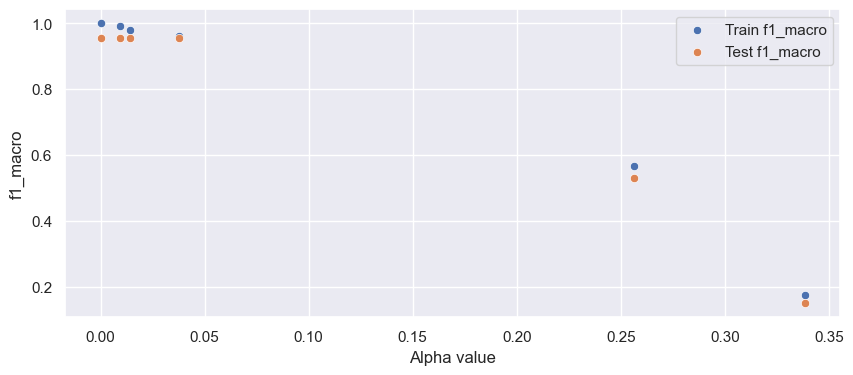

In [37]:
accuracy_train,accuracy_test=[],[]
for i in alphas:
    tree=DecisionTreeClassifier(ccp_alpha=i)
    
    tree.fit(x_train,y_train)
    y_train_pred=tree.predict(x_train)
    y_test_pred=tree.predict(x_test)
    
    accuracy_train.append(f1_score(y_train,y_train_pred, average='macro'))
    accuracy_test.append(f1_score(y_test,y_test_pred, average='macro'))
    
    
sns.set()
plt.figure(figsize=(10,4))
sns.scatterplot(y=accuracy_train,x=alphas,label="Train f1_macro")
sns.scatterplot(y=accuracy_test,x=alphas,label="Test f1_macro")
plt.xticks()
plt.xlabel("Alpha value")
plt.ylabel("f1_macro")
plt.show()

# Class Weights testing

{'Iris-setosa': 1, 'Iris-versicolor': 1, 'Iris-virginica': 1}
[1.         0.95008913 1.         0.95213675 0.85026738]
{'Iris-setosa': 1, 'Iris-versicolor': 2, 'Iris-virginica': 1}
[1.         0.95008913 1.         0.95213675 0.85026738]
{'Iris-setosa': 2, 'Iris-versicolor': 10, 'Iris-virginica': 1}
[1.         0.95008913 1.         0.95213675 0.85026738]
{'Iris-setosa': 2, 'Iris-versicolor': 3, 'Iris-virginica': 1}
[1.         0.95008913 1.         0.95213675 0.85026738]
{'Iris-setosa': 1, 'Iris-versicolor': 2, 'Iris-virginica': 3}
[0.95008913 0.95008913 1.         0.9047619  0.85026738]
[0.9504986516751222, 0.9504986516751222, 0.9504986516751222, 0.9504986516751222, 0.9310415075120957]


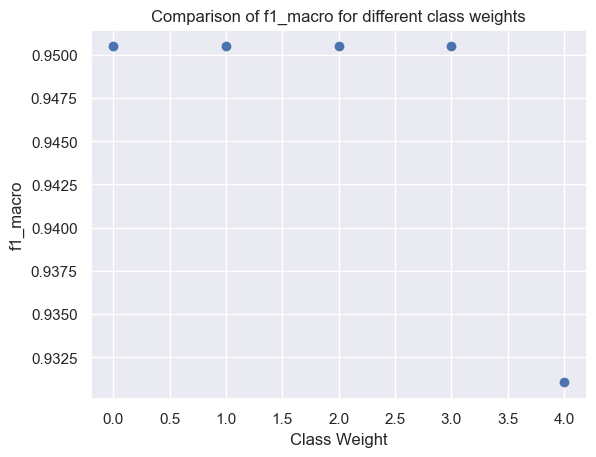

In [38]:
from sklearn.model_selection import cross_val_score

class_weights = [
 {'Iris-setosa': 1, 'Iris-versicolor': 1, 'Iris-virginica': 1},
 {'Iris-setosa': 1, 'Iris-versicolor': 2, 'Iris-virginica': 1},
 {'Iris-setosa': 2, 'Iris-versicolor': 10, 'Iris-virginica': 1},
 {'Iris-setosa': 2, 'Iris-versicolor': 3, 'Iris-virginica': 1},
 {'Iris-setosa': 1, 'Iris-versicolor': 2, 'Iris-virginica': 3}
]

mean_scores = []
for i, weight in enumerate(class_weights):
    print(weight)
    clf = DecisionTreeClassifier(class_weight=weight)
    scores = cross_val_score(clf, x_train, y_train, cv=5, scoring='f1_macro')
    print(scores)
    mean_scores.append(np.mean(scores))

print(mean_scores)

plt.scatter([0, 1,2,3,4 ], mean_scores)
plt.xlabel('Class Weight')
plt.ylabel('f1_macro')
plt.title('Comparison of f1_macro for different class weights')
plt.show()

-------------------------------------------------
#  Polish Companies Bankruptcy
-------------------------------------------------

In [39]:
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.io import arff

data = arff.loadarff('2year.arff')
bank_df = pd.DataFrame(data[0])
bank_df = bank_df.drop(columns=['Attr37', 'Attr21'])
x = bank_df.iloc[:, :-1]
y = bank_df.iloc[:, -1]
y = MultiLabelBinarizer().fit_transform(y)
y = pd.Series(y[: , 1])
print(y)

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                   test_size = 0.25,
                                                   shuffle = True, #shuffle the data to avoid bias
                                                   random_state= 0)

FileNotFoundError: [Errno 2] No such file or directory: '2year.arff'

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
clf = DecisionTreeClassifier()
pipe = Pipeline([('median_inputer', SimpleImputer(strategy='median')),
                 #('scaler', StandardScaler()),
                 ('clf', DecisionTreeClassifier())])
pipe.fit(x_train, y_train)
print(f1_score(y_test, pipe.predict(x_test), average='macro'))

In [ ]:
X_preproc = pipe[:-1].transform(x_train)
path = pipe.steps[-1][1].cost_complexity_pruning_path(X_preproc, y_train)
##
alphas = path['ccp_alphas']

In [ ]:
parameters = {'clf__criterion':('gini', 'entropy'),
              'clf__max_depth':[2, 4, 6, 8, 10,],
              'clf__min_samples_leaf': [1, 2, 3, 4, 5, 10],
#             'clf__ccp_alpha': alphas
             }
grid_search = GridSearchCV(pipe, parameters, cv=5, verbose=10, n_jobs=-1, scoring='f1_macro')
grid_search.fit(x_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)
### na testowym
y_pred = grid_search.best_estimator_.predict(x_test)
print("Na testowym: ", f1_score(y_test, y_pred, average='macro'))
###

100%|██████████| 6/6 [00:00<00:00, 99.76it/s]


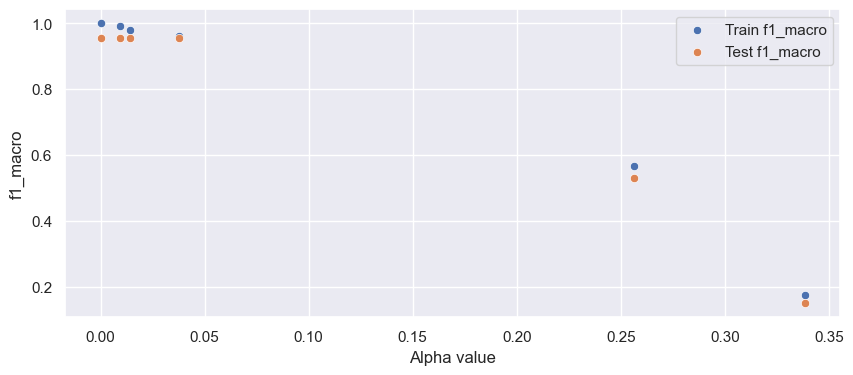

In [42]:
from sklearn.impute import SimpleImputer
from tqdm import tqdm

accuracy_train, accuracy_test = [], []
for i in tqdm(alphas):
    clf = DecisionTreeClassifier(ccp_alpha=i)
    pipe = Pipeline([('median_inputer', SimpleImputer(strategy='median')),
                     ('clf', clf)])
    pipe.fit(x_train, y_train)
    y_train_pred = pipe.predict(x_train)
    y_test_pred = pipe.predict(x_test)

    accuracy_train.append(f1_score(y_train, y_train_pred, average='macro'))
    accuracy_test.append(f1_score(y_test, y_test_pred, average='macro'))

sns.set()
plt.figure(figsize=(10, 4))
sns.scatterplot(y=accuracy_train, x=alphas, label="Train f1_macro")
sns.scatterplot(y=accuracy_test, x=alphas, label="Test f1_macro")
plt.xticks()
plt.xlabel("Alpha value")
plt.ylabel("f1_macro")
plt.show()